In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
!jupyter nbextension enable --py widgetsnbextension
from scipy.optimize import minimize

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
%matplotlib inline

In the previous tutorial we studied the *regression* problem. This is, the target $y$ of the problem, was a continuous variable. In this tutorial we will study the *classification* problem in which the target $y$ is a discrete variable. For instance...

In [4]:
data_1 = np.genfromtxt("ex2data1.txt",delimiter = ',')
data_2 = np.genfromtxt("ex2data2.txt",delimiter = ',')

In [5]:
X = np.ones((data_1.shape[0],3))
X[:,1:3] = data_1[:,:2]
y = data_1[:,-1]

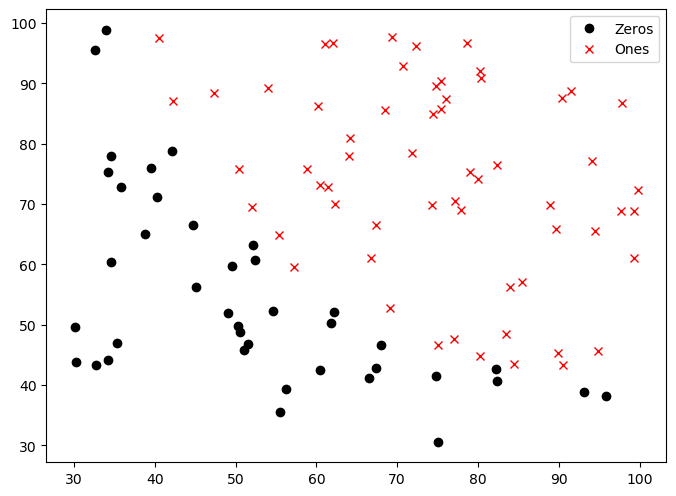

In [6]:
plt.figure(figsize = (8,6), dpi = 100)
plt.plot(X[y==0,1], X[y==0,2], "o", label = "Zeros", c = 'k')
plt.plot(X[y==1,1], X[y==1,2], "x", label = "Ones",c = 'r')
plt.legend()

In the classification problem one would like to find a frontier that separates the data according to its labels. The starting point of the logistic regression is the *sigmoid function* $\sigma(z)$,

\begin{equation}
\sigma(z) = \frac{1}{1+e^{-z}}
\end{equation}

In [7]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

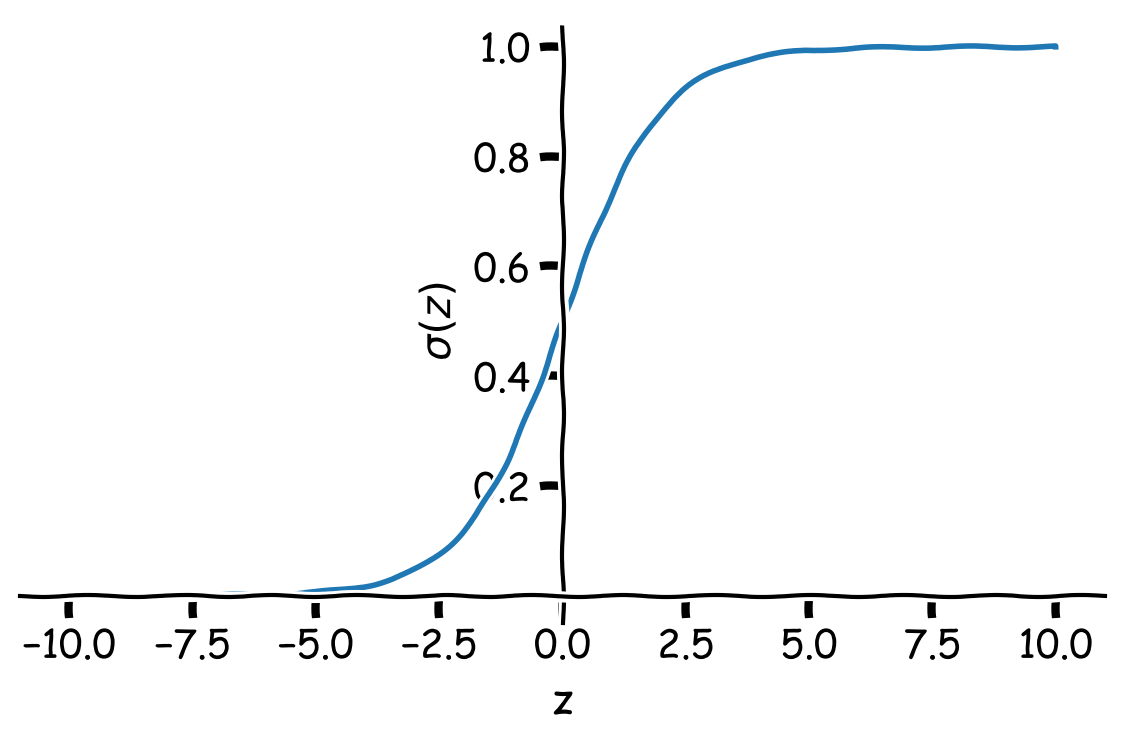

In [8]:
with plt.xkcd():
    zs = np.linspace(-10,10,1000)
    fig, ax = plt.subplots(figsize = (7,4), dpi=200)
    ax.plot(zs, sigmoid(zs))
    #ax.set_aspect('equal')
    ax.grid(True, which='both')

    # set the x-spine (see below for more info on `set_position`)
    ax.spines['left'].set_position('zero')

    # turn off the right spine/ticks
    ax.spines['right'].set_color('none')
    ax.yaxis.tick_left()

    # set the y-spine
    ax.spines['bottom'].set_position('zero')

    # turn off the top spine/ticks
    ax.spines['top'].set_color('none')
    ax.xaxis.tick_bottom()
    
    ax.set_yticks([0.2,0.4,0.6,0.8,1.0])
    ax.set_xlabel("z", fontsize = 15)
    ax.set_ylabel(r"$\sigma(z)$", fontsize = 15)
    


Notice that the effect of the sigmoid function is to sqeeze any input value into the (0,1) range. Now, one could extend the sigmoid function to multiple inputs by letting the input be the dot product between a input vector $\pmb{x}$ and a parameter vector $\pmb{\theta}$, such that,

\begin{equation}
  \sigma_\theta(\pmb{x}) = \sigma(\pmb{\theta}^T\pmb{x} + \theta_0) = \frac{1}{1+\exp-\left(\pmb{\theta}^T\pmb{x} +\theta_0\right)}.
\end{equation}

Let's now understand the sigmoid function behaves with multiple parametersInitially we will consider the case where $\theta_0 = 0$. Consider the $\pmb{\theta}^T\pmb{x}$ operation which is basically the dot product between vector $\pmb{\theta}$ and $\pmb{x}$. Therfore,

\begin{equation}
    \pmb{\theta}^T\pmb{x} = ||\pmb{x}||\cdot||\pmb{\theta}||\cos\beta,
\end{equation}

where $\beta$ is the angle between the $\pmb{x}$ and $\pmb{\theta}$ vectors. Therefore, the dot product gets maximised if the two vectors are parallel, minimised if they are antiparallel and is becomes zero if they are orthogonal. This three cases will yield the following values:

\begin{equation}
    \sigma_{\beta = 0} = \sigma(||\pmb{x}||\cdot||\pmb{\theta}||) = \frac{1}{1+\exp\left(-||\pmb{x}||\cdot||\pmb{\theta}||\right)},
\end{equation}

\begin{equation}
    \sigma_{\beta = \pi/2} = \sigma(0) = \frac{1}{2},
\end{equation}

\begin{equation}
    \sigma_{\beta = \pi} = \sigma(||\pmb{x}||\cdot||\pmb{\theta}||) = \frac{1}{1+\exp\left(||\pmb{x}||\cdot||\pmb{\theta}||\right)}.
\end{equation}

In this sense,the sigmoid function will tend to $1$ if the $\pmb{\theta}$ and $\pmb{x}$ vectors are to close (parallel) to each other, and their magnitudes are big.  On the opposite, the sigmoid function will tend to $0$ if the $\pmb{\theta}$ and $\pmb{x}$ vectors are to opposite (antiparallel) to each other, and their magnitudes are big. The sigmoid function will output $\frac{1}{2}$ if the vectors are orthogonal, independently of their magnitude. The effect of $\theta_0$ is to shift the plot in the direction of $\pmb{\theta}$.

In [9]:
@interact(theta_0 = (-10,10,0.01), theta_1 = (-1,1,0.01), theta_2 = (-1,1,0.01))
def plot(theta_0, theta_1, theta_2):
    theta = np.array([theta_0, theta_1, theta_2])
    x_1 = np.linspace(-15,15,100)
    x_2 = np.linspace(-15,15,100)
    x1_mesh, x2_mesh = np.meshgrid(x_1, x_2)
    plt.figure(figsize = (8,8))
    twod_sigmoid = [sigmoid(theta.T@np.array([1,x1,x2])) for x1 in x_1 for x2 in x_2]
    twod_sigmoid = np.array(twod_sigmoid).reshape((100,100))
    plt.contourf(x1_mesh,x2_mesh,twod_sigmoid, 100,cmap="Blues")
    CS = plt.contour(x1_mesh,x2_mesh,twod_sigmoid, 20,cmap="gray")
    #Todo change arrow size dynamically
    plt.quiver(0,0,theta_2,theta_1)
    plt.clabel(CS, inline=1, fontsize=10)


interactive(children=(FloatSlider(value=0.0, description='theta_0', max=10.0, min=-10.0, step=0.01), FloatSlid…

How can the sigmoid function be used to create a classifier? Well, it is possible to think of $\sigma_\theta(\pmb{x})$ as the probability of an input $\pmb{x}$ beloning to the class $y=1$. This is the same as,

\begin{equation}
    \sigma_\theta(\pmb{x}) = P(y=1|\pmb{x}, \pmb{\theta}).
\end{equation}

Then, one would like to find the $\hat{\theta}$ such that the classifier labels correctly as many inputs possible as possible. The labeling can be determined if the output is grater of lesser than 0.5. Similarly as in the linear regressiom, in order to find the optimal weights $\hat{\theta}$, we need to define a loss function and optimise it. Given a set of data $\{x_i,y_i\}_{i=1}^{M}$, the starting point to define a loss function, is the *Likelihood function* define as,

\begin{equation}
    L(\theta) = \prod_{i=1}^M P(y_i|\pmb{x}_i, \pmb{\theta}).
\end{equation}

The lieklihood function is the probability of the data given the parameter, therefore by *maximising* the likelihood function one would be finding the parameter vector that ??? In paractice it is more convinient to minimise the *negative log likelihood* (basically logarithms convert products into sums which are computationally more  convinient to work with) $\text{NLL} = -\log L(\pmb{\theta})$. Then our cost function will be,

\begin{equation}
    J_D(\theta) = \frac{1}{M}\text{NLL} = -\frac{1}{M}\sum_{i=1}^M \log P(y_i|\pmb{x}_i, \pmb{\theta}).
\end{equation}

Finally, we need to define what is $P(y_i|\pmb{x}_i, \pmb{\theta})$. We have already define $P(y=1|\pmb{x}, \pmb{\theta}) = \sigma_\theta(\pmb{x})$, and by normalisation of probabilities, $P(y=0|\pmb{x}, \pmb{\theta}) = 1 -\sigma_\theta(\pmb{x})$, then its possible to express $P(y_i|\pmb{x}_i, \pmb{\theta})$ compactly as,

\begin{equation}
   P(y_i|\pmb{x}_i, \pmb{\theta}) = \sigma_\theta(\pmb{x}_i)^{y_i}\left(1 -\sigma_\theta(\pmb{x}_i)\right)^{1-y_i} = 
   \begin{cases}
   \sigma_\theta(\pmb{x}_i)\text{  if  }y=0\\
   1-\sigma_\theta(\pmb{x}_i)\text{  if  }y=1
   \end{cases},
\end{equation}

and,

\begin{equation}
    J_D(\theta) = \frac{1}{M}\text{NLL} = -\frac{1}{M}\sum_{i=1}^M \left[y_i\log \sigma_\theta(\pmb{x}) + (1-y_i)\log(1-\sigma_\theta(\pmb{x}))\right].
\end{equation}

To intuitively understand why this loss function works, let's take a case where the the innter part of the sum. If the correct label of an input $\pmb{x}_i$ is 1, the second term of the sum will be killed (in viceversa) leaving us with the loss of that item being $\log\sigma_\theta(\pmb{x})$. If the output of the classifier is close to 1, the log will go to zero and there won't be increase in the loss. However, if the output of the classifier is close to 0 when the label is one, the log will go to $-\inf$ increasing the loss hugely. If the classification is done incorrecly or correcly by a low margin (i.e. 0.499 or 5.01) the loss will be almost the same. In this sense, the loss function penalizes really strongly **confident missclasification**, which has some good properties, but can make the model very sensible to outliers.

Note on cross entropy and information theory!!!

In [10]:
def logistic_regression_cost(theta, X, y):

    m = X.shape[0]
    cost = np.sum(-y*np.log(sigmoid(X@theta)) - (1-y)*np.log(1 - sigmoid(X@theta)))
    return cost/m

def logistic_regression_grad(theta, X, y):
    
    m = X.shape[0]
    return X.T@(sigmoid(X@theta) - y)/m

def logistic_regression_cost_2(theta, X, y):
    
    z = (2*y -1).reshape((100,1))
    m = X.shape[0]
    cost = - np.sum(np.log(sigmoid(theta, z*X)))
    return cost/m

In order to optimise the cost function, one could use the alpha gradient descent method as shown in the previous tutorial. For these one would need to find the gradients of the loss function with respect to the parameters. This is done as follows,



\begin{equation}
   \nabla_{\pmb{\theta}}J_D(\theta) = -\nabla_{\pmb{\theta}}\left(\frac{1}{M}\sum_{i=1}^M \left[y_i\log \sigma_\theta(\pmb{x}_i) + (1-y_i)\log(1-\sigma_\theta(\pmb{x}_i))\right]\right),
\end{equation}

which by linearity of the derivative, is, 


\begin{equation}
   \nabla_{\pmb{\theta}}J_D(\theta) = -\frac{1}{M}\sum_{i=1}^M \left[\nabla_{\pmb{\theta}}(y_i\log \sigma_\theta(\pmb{x}_i)) + \nabla_{\pmb{\theta}}((1-y_i)\log(1-\sigma_\theta(\pmb{x}_i))\right],
\end{equation}

then, using the *chain rule* and the fact that,

\begin{equation}
    \frac{\partial \log f(z)}{\partial z} = \frac{1}{\sigma(z)}\frac{\partial f(z)}{\partial z}, 
\end{equation}

\begin{equation}
    \frac{\partial \sigma(z)}{\partial z} = \sigma(z)(1-\sigma(z)), 
\end{equation}

we get,

\begin{equation}
    \nabla_{\pmb{\theta}}J_D(\theta) = -\frac{1}{M}\sum_{i=i}^M \left[\frac{y_i}{\sigma_\theta(\pmb{x}_i)}\sigma_\theta(\pmb{x}_i)(1-\sigma_\theta(\pmb{x}_i))\nabla_{\pmb{\theta}}(\pmb{\theta}^T \pmb{x}_i) - \frac{1 - y_i}{1-\sigma_\theta(\pmb{x}_i)}\sigma_\theta(\pmb{x}_i)(1-\sigma_\theta(\pmb{x}_i))\nabla_{\pmb{\theta}}(\pmb{\theta}^T \pmb{x}_i)\right],
\end{equation}

\begin{equation}
    \nabla_{\pmb{\theta}}J_D(\theta) = -\frac{1}{M}\sum_{i=i}^M \left(y_i(1-\sigma_\theta(\pmb{x}_i))\pmb{x}_i - (1 - y_i)\sigma_\theta(\pmb{x}_i)\pmb{x}_i\right),
\end{equation}



\begin{equation}
    \nabla_{\pmb{\theta}}J_D(\pmb{\theta}) = -\frac{1}{M}\sum_{i=1}^M \left[-y_i\sigma_\theta(\pmb{x}_i)\pmb{x}_i + y_i\pmb{x}_i- \sigma_\theta(\pmb{x}_i)\pmb{x}_i + y_i\sigma_\theta(\pmb{x}_i)\pmb{x}_i\right]= -\frac{1}{M}\sum_{i=1}^M y_i\pmb{x}_i- \sigma_\theta(\pmb{x}_i)\pmb{x}_i ,
\end{equation}

\begin{equation}
    \nabla_{\pmb{\theta}}J_D(\pmb{\theta}) = \frac{1}{M} \sum_{i=1}^M (\sigma_\theta(\pmb{x}) - y_i)\pmb{x},
\end{equation}

which can be rewritten in a vectorised form as,

\begin{equation}
    \nabla_{\pmb{\theta}}J_D(\pmb{\theta}) = \frac{1}{M}X^T(\sigma_\theta(\pmb{x}) - y_i).
\end{equation}

In [11]:
def logistic_regression_fit(X,y, theta_init = None):

    if theta_init is None:
        theta_init = np.random.random(X.shape[1])/X.shape[0]
        
    optimisation = minimize(logistic_regression_cost, theta_init, args = (X, y)) #<-- this is the important line
    if optimisation["success"]:
        theta_resp = optimisation["x"]
        print("Optimal paramiters:", theta_resp)
        print("Accuracy :", np.sum((sigmoid(X@theta_resp) > 0.5) == y)/len(y))
        print("Convergence loss:", round(optimisation["fun"],4))
        return theta_resp

    else: 
        print("Optimisation was not succesful, try other initial parameters")
        

In [12]:
theta_optim_1 = logistic_regression_fit(X,y, theta_init = np.array([1,0.1,0.1]))

Optimal paramiters: [-25.16120854   0.20623074   0.20147054]
Accuracy : 0.89
Convergence loss: 0.2035


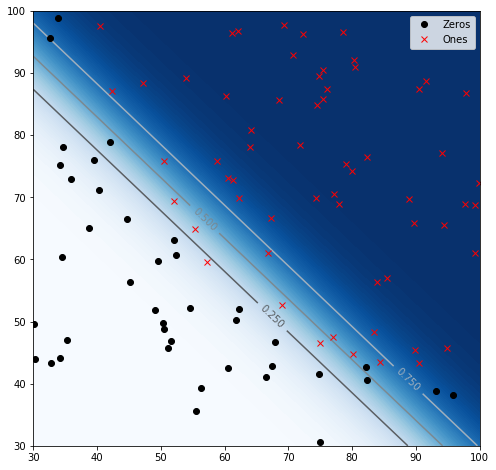

In [13]:
theta_0, theta_1, theta_2 = theta_optim_1[0], theta_optim_1[1], theta_optim_1[2]
x_1s = np.linspace(30,100,100)
x_2s = np.linspace(30,100,100)

xs= np.array([[1,x_1,x_2] for x_1 in x_1s for x_2 in x_2s])

x1_mesh, x2_mesh = np.meshgrid(x_1s, x_2s)
plt.figure(figsize = (8,8))
plt.contourf(x1_mesh,x2_mesh,sigmoid(xs@np.array([theta_0,theta_1,theta_2])).reshape(100,100), 100,cmap="Blues")
CS = plt.contour(x1_mesh,x2_mesh,sigmoid(xs@np.array([theta_0,theta_1,theta_2])).reshape(100,100), 3,cmap = 'gray', alpha = 0.8)
#plt.quiver(0,0,theta_2,theta_1)
plt.clabel(CS, inline=1, fontsize=10)
plt.plot(X[y==0,1], X[y==0,2], "o", label = "Zeros", c = 'k')
plt.plot(X[y==1,1], X[y==1,2], "x", label = "Ones", c = 'r')
plt.legend()

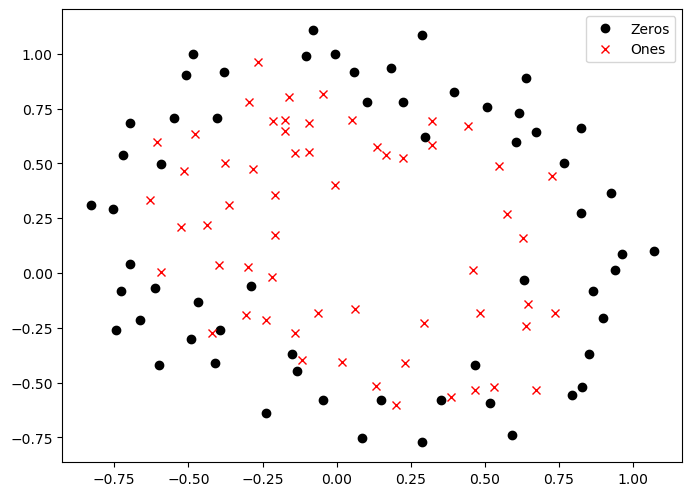

In [14]:
X2 = np.ones((data_2.shape[0],3))
X2[:,1:3] = data_2[:,:2]
y2 = data_2[:,-1]

plt.figure(figsize = (8,6), dpi = 100)
plt.plot(X2[y2==0,1], X2[y2==0,2], "o", label = "Zeros", c = "k")
plt.plot(X2[y2==1,1], X2[y2==1,2], "x", label = "Ones" ,c = 'r')
plt.legend()

In [15]:
def map_to_higher(data_x_1, data_x_2, degree = 4):
    
    out = np.ones((data_x_1.shape[0], int((degree+1)*(degree+2)/2)))
    
    index = 1
    for i in range(1, degree+1):
        for j in range(i + 1):
            out[:, index] = data_x_1**(i-j)*data_x_2**(j)
            index +=1 
            
    return out

In [16]:
@interact(degree = (1,7))
def plot_classifier_higher_dim(degree):
    X_hd = map_to_higher(data_2[:,0], data_2[:, 1], degree) 
    theta_optim_2 = logistic_regression_fit(X_hd, y2)

    x_1s = np.linspace(-1,1.25,100)
    x_2s = np.linspace(-1,1.25,100)
    higher_dim_resp = np.array([map_to_higher(np.array([x_1]), np.array([x_2]), degree) for x_1 in x_1s for x_2 in x_2s]).squeeze()

    xx_1, xx_2 = np.meshgrid(x_1s, x_2s)
    plt.figure(figsize = (8,8),dpi=100)
    plt.contourf(xx_1, xx_2, sigmoid(higher_dim_resp@theta_optim_2).reshape(100,100),100, cmap="Blues")
    CS = plt.contour(xx_1, xx_2, sigmoid(higher_dim_resp@theta_optim_2).reshape(100,100), [0.5], cmap = "gray")
    CS = plt.contour(xx_1, xx_2, sigmoid(higher_dim_resp@theta_optim_2).reshape(100,100), [0.25,0.75], cmap = "gray", alpha = 0.2)
    plt.clabel(CS, inline=1, fontsize=10)
    _=plt.plot(X2[y2==0,1], X2[y2==0,2], "o", label = "Zeros", c= 'k')
    _=plt.plot(X2[y2==1,1], X2[y2==1,2], "x", label = "Ones", c= 'r')

interactive(children=(IntSlider(value=4, description='degree', max=7, min=1), Output()), _dom_classes=('widget…